# Buidling and Testing a Variational Autoencoder (VAE) from Scratch

## By A.J. Beiza for ITSC 3156

In [1]:
import os
import shutil
import json
import sys
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from typing import List, Tuple, Union, Dict
from torchvision.datasets import MNIST
import torch
from torch import optim
import torch.nn as nn
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from sklearn.datasets import fetch_lfw_people
from datetime import datetime


from google.colab import drive
drive.mount('/content/drive')

working_dir = os.getcwd()
date = datetime.strftime(datetime.now(), "%Y-%m-%d-%H%M%S")

torch.manual_seed(7262005)  # bday
np.random.seed(7262005)
plt.ioff()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Download MNIST Dataset from PyTorch for use with the simple linear VAE

In [4]:
mnist_download_dir = os.path.abspath("/content/drive/MyDrive/VariationalAutoEncoders/data/MNIST_downloaded")

# mnist_download_dir = os.path.join(working_dir, "data", "MNIST_downloaded")

if not os.path.exists(os.path.join(working_dir, "data")):
    os.makedirs(os.path.join(working_dir, "data"))
if not os.path.exists(mnist_download_dir):
    os.makedirs(mnist_download_dir, exist_ok=True)

if len(os.listdir(mnist_download_dir)) == 0:
    download = True
else:
    download = False

mnist_dataset = MNIST(
    root=mnist_download_dir,
    train=True,
    download=download,
    transform=T.Compose([
        T.ToTensor(),
        T.Lambda(lambda x: x.numpy())
    ])
)

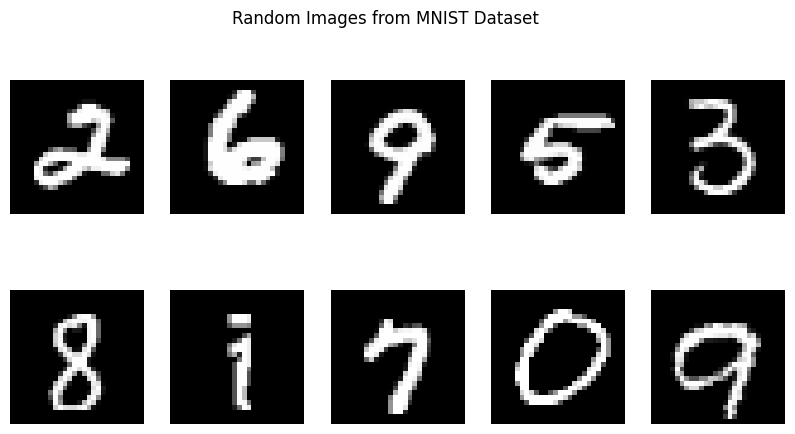

In [5]:
def visualize_rnd_imgs(dataset: Dataset, nrow:int, ncol:int, img_idx:int, greyscale:bool, reshape:callable):

  """
  dataset: A PyTorch dataset with the len() and __get_item__() methods implemented
  nrow: The number of rows in the figure
  ncol: The number of columns in the figure
  img_idx: The index of the image/tensor/array in the tuple returned by dataset.__getitem__()

  Returns:
  fig: Matplotlib figure
  axs: list of matplotlib axes
  """

  rnd_idxs = np.random.choice(np.arange(len(dataset)), size=nrow*ncol)
  fig, axs = plt.subplots(nrow, ncol, figsize=(10, 5))
  flat_axs = axs.flatten()
  for i, idx in enumerate(rnd_idxs):
      img = dataset[idx][img_idx]

      if greyscale:
        flat_axs[i].imshow(reshape(img), cmap="Greys_r")
      else:
        flat_axs[i].imshow(reshape(img))

      flat_axs[i].axis("off")

  return fig, axs

fig, _ = visualize_rnd_imgs(mnist_dataset, nrow=2, ncol=5, img_idx=0, greyscale=True, reshape= lambda x: x.reshape(28, 28))
fig.suptitle("Random Images from MNIST Dataset")
plt.show()

# Download Labeled Faces in the Wild (LFW) Dataset for use with the Convolutional VAE (CVAE)

To explore the full potential of the VAE architecture, a more complex dataset with more complex layers can be used. Convolutional layers are better equipped to understand and model images because they are not treating pixels as indivdual features and can model the spatial relationship of pictures better.

This code does take a very long time to run (~30-40 minutes) if the dataset is not downloaded

In [4]:
# lfw_download_dir = os.path.join(working_dir, "data", "LFW_downloaded")
# lfw_out_dir = os.path.join(working_dir, "data", "LFW")

# os.makedirs(os.path.join(working_dir, "data"), exist_ok=True)
# os.makedirs(lfw_download_dir, exist_ok=True)
# os.makedirs(lfw_out_dir, exist_ok=True)

# # download dataset if needed
# if len(os.listdir(lfw_out_dir)) == 0:

#     lfw = fetch_lfw_people(
#         data_home=lfw_download_dir,
#         funneled=True,  # cleaned version of the dataset
#         download_if_missing=True
#     )

#     """
#     Walk through downloaded folder structure which makes
#     a folder for each person and flatten the folders to one
#     folder with all images (since labels are not needed for
#     this unsupervised task
#     """
#     i = 0
#     for root, dirs, files in os.walk(lfw_download_dir):
#         for f in files:
#             if f.endswith(".jpg"):
#                 person_name = "_".join(f.split("_")[:2])
#                 # new file name with 0 padding
#                 new_name = f"lfw_{i:06d}_{person_name}.jpg"
#                 shutil.copy(
#                     os.path.join(root, f),
#                     os.path.join(lfw_out_dir, new_name)
#                 )
#                 i += 1
#     print(f"All files moved to {lfw_out_dir}")

Use the folder path to create a class inheriting from Dataset to allow for easy integration with other PyTorch classes, such as DataLoader for Mini batch training

In [2]:
class LFWDataset(Dataset):

    def __init__(self, folder_path: str, transform=None, greyscale=False):
        assert os.path.exists(folder_path), f"Folder Path: {folder_path} does not exist"
        self.path = folder_path
        self.img_nms = os.listdir(folder_path)
        self.transform = transform
        self.color = "L" if greyscale else "RGB"

    def __len__(self)->int:
        return len(self.img_nms)

    def __getitem__(self, idx)->Union[torch.Tensor, np.ndarray, Image]:
        f_name = os.path.join(self.path, self.img_nms[idx])
        person_name = " ".join(f_name.split("_")[-2:])
        img = Image.open(f_name).convert(self.color)
        if self.transform is not None:
            img = self.transform(img)
        img = img.to(torch.float32)
        img = torch.clamp(img, min=0.0, max=1.0)
        return (img, person_name)

lfw_transform = T.Compose([
    T.ToTensor(),
    T.Resize((64, 64))
])

lfw_out_dir = "/content/drive/MyDrive/VariationalAutoEncoders/data/LFW"
lfw_dataset = LFWDataset(folder_path=lfw_out_dir, transform=lfw_transform)

Visualize random samples from the LFW Dataset

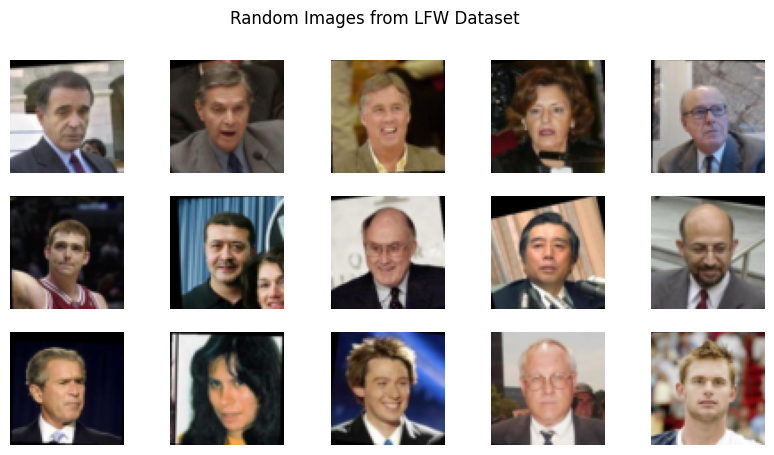

In [7]:
fig, _ = visualize_rnd_imgs(
    dataset=lfw_dataset,
    nrow=3,
    ncol=5,
    img_idx=0,
    greyscale=False,
    reshape= lambda x: x.permute(1, 2, 0)
)
fig.suptitle("Random Images from LFW Dataset")
plt.show()


In [26]:
class VariationalAutoencoder:

    def __init__(
            self,
            lr:float,
            l1_dim:int,
            l2_dim:int,
            latent_dim:int,
            l4_dim:int,
            l5_dim:int,
            mse:bool  # uses cross entropy loss for reconstruction loss if False
        ):

        self.lr = lr
        self.l1_dim = l1_dim
        self.l2_dim = l2_dim
        self.latent_dim = latent_dim
        self.l4_dim = l4_dim
        self.l5_dim = l5_dim
        self.beta = 0
        self.mse = mse
        self.params_init = False  # used to avoid initiaizing params >1x
        self.test_losses = {"Recon Loss": [], "KL Loss": [], "ELBO Loss": []}
        self.train_losses = {"Recon Loss": [], "KL Loss": [], "ELBO Loss": []}


    def he_init(self, fan_in:int, shape:Tuple)->np.ndarray:

        std = np.sqrt(2.0 / fan_in)
        return np.random.normal(loc=0, scale=std, size=shape)


    def init_params(self, dim:int):

        # first hidden layer weights + bias
        self.W1_enc = self.he_init(fan_in=dim, shape=(dim, self.l1_dim))  # dim x l1_dim
        self.b1_enc = np.zeros((self.l1_dim, ))  # l1_dim x 1

        # second hidden layer weights + bias
        self.W2_enc = self.he_init(fan_in=self.l1_dim, shape=(self.l1_dim, self.l2_dim))  # l1_dim x l2_dim
        self.b2_enc = np.zeros((self.l2_dim, ))  # l2_dim x 1
        # mu of latent space layer weights + bias
        # self.Wmu = np.random.normal(loc=0, scale=0, size=(self.l2_dim, self.latent_dim))
        self.Wmu = self.he_init(fan_in=self.l2_dim, shape=(self.l2_dim, self.latent_dim))
        self.bmu = np.zeros((self.latent_dim, ))  # latent_dim x 1

        # std of latent space layer weights + bias
        # self.Wstd = np.random.normal(loc=0, scale=0, size=(self.l2_dim, self.latent_dim))
        self.Wstd = self.he_init(fan_in=self.l2_dim, shape=(self.l2_dim, self.latent_dim))
        self.bstd = np.zeros((self.latent_dim, ))  # latent_dim x 1

        # 4th hidden layer weights + bias (first hidden layer of decoder)
        self.W1_dec = self.he_init(fan_in=self.latent_dim, shape=(self.latent_dim, self.l4_dim))
        self.b1_dec = np.zeros((self.l4_dim, ))

        # 5th hidden layer weights + bias
        self.W2_dec = self.he_init(fan_in=self.l4_dim, shape=(self.l4_dim, self.l5_dim))
        self.b2_dec = np.zeros((self.l5_dim, ))

        # output layer weights + bias
        self.W3_dec = self.he_init(fan_in=self.l5_dim, shape=(self.l5_dim, dim))
        self.b3_dec = np.zeros((dim, ))

        # init gradients
        self.W1_enc_d = np.zeros_like(self.W1_enc)
        self.b1_enc_d = np.zeros_like(self.b1_enc)
        self.W2_enc_d = np.zeros_like(self.W2_enc)
        self.b2_enc_d = np.zeros_like(self.b2_enc)
        self.Wmu_d = np.zeros_like(self.Wmu)
        self.bmu_d = np.zeros_like(self.bmu)
        self.Wstd_d = np.zeros_like(self.Wstd)
        self.bstd_d = np.zeros_like(self.bstd)
        self.W1_dec_d = np.zeros_like(self.W1_dec)
        self.b1_dec_d = np.zeros_like(self.b1_dec)
        self.W2_dec_d = np.zeros_like(self.W2_dec)
        self.b2_dec_d = np.zeros_like(self.b2_dec)
        self.W3_dec_d = np.zeros_like(self.W3_dec)
        self.b3_dec_d = np.zeros_like(self.b3_dec)
        self.params_init = True  # mark params as initialized

    def relu(self, X, derivative=False):

        if not derivative:
            return (X > 0) * X
        return (X > 0) * 1


    def lrelu(self, x, alpha=0.1, derivative=False):

        if not derivative:
          return np.where(x > 0, x, alpha * x)
        drv = np.ones_like(x)
        drv[x < 0] = alpha
        return drv


    def encoder(self, X: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:

        # check if parameters have been init. yet
        if not self.params_init:
            self.init_params(X.shape[1])

        self.z1_enc = X @ self.W1_enc + self.b1_enc
        self.a1_enc = self.lrelu(self.z1_enc)

        self.z2_enc = self.a1_enc @ self.W2_enc + self.b2_enc
        self.a2_enc = self.lrelu(self.z2_enc)

        self.mu = self.a2_enc @ self.Wmu + self.bmu
        self.logvar = self.a2_enc @ self.Wstd + self.bstd

        return self.mu, self.logvar

    def reparametrize(self, mu: np.ndarray, logvar: np.ndarray, length: int)->np.ndarray:

        self.eps = np.random.standard_normal(size=(length, self.latent_dim))
        return mu + np.exp(0.5*logvar) * self.eps

    def decoder(self, Z:np.ndarray) -> np.ndarray:

        self.z1_dec = Z @ self.W1_dec + self.b1_dec
        self.a1_dec = self.lrelu(self.z1_dec)

        self.z2_dec = self.a1_dec @ self.W2_dec + self.b2_dec
        self.a2_dec = self.lrelu(self.z2_dec)

        mu_x = self.a2_dec @ self.W3_dec + self.b3_dec

        return mu_x  # these are interpreted as logits if self.mse is false

    def forward(self, X: np.ndarray) -> np.ndarray:

        # check if parameters have been init. yet
        if not self.params_init:
            self.init_params(X.shape[1])

        mu, logvar = self.encoder(X)
        self.z = self.reparametrize(mu=mu, logvar=logvar, length=X.shape[0])
        mu_x = self.decoder(self.z)
        return mu_x, mu, logvar

    def sigmoid(self, x):
        """
        Numerically stable way to compute sigmoid. This method was written by
        ChatGPT after I discussed numerical stability issues I was having while
        training the VAE.
        """
        pos = x >= 0
        z = np.zeros_like(x)
        z[pos]  = 1.0 / (1.0 + np.exp(-x[pos]))
        z[~pos] = np.exp(x[~pos]) / (1.0 + np.exp(x[~pos]))
        return z

    def bce_with_logits(self, logits, targets):
        """
        Numerically stable way to calculate binary cross entropy loss using logits.
        This method was written by ChatGPT after I discussed numerical stability
        issues I was having while training the VAE.
        """
        x, y = logits, targets
        loss_px = np.maximum(x, 0) - x*y + np.log1p(np.exp(-np.abs(x)))
        return np.mean(np.sum(loss_px, axis=1))

    def loss(self, X:np.ndarray, mu_x:np.ndarray, logvar:np.ndarray, mu:np.ndarray)->float:

        kl_div = np.mean(-0.5 * np.sum(1 + logvar - mu**2 - np.exp(logvar), axis=1))
        if not self.mse:
            recon_loss = self.bce_with_logits(mu_x, X)
        else:
            recon_loss = np.mean(np.sum((mu_x-X)**2, axis=1))
        elbo = recon_loss + self.beta * kl_div
        return recon_loss, kl_div, elbo

    def backwards(self, X, mu_x, logvar, mu)->None:


        dnm = len(X)**(-1)  # denominator to average across batch

        ##############################################
        ##### DECODER GRADS #########################
        ##############################################

        # drl refers to deriviative of Reconstruction loss. KL loss can be ignored for decoder since
        # it does not depend on decoder weights/biases

        if not self.mse:
            p = self.sigmoid(mu_x)
            drl_dmu_x = (p - X)
        else:
            drl_dmu_x = 2*(mu_x-X)

        self.W3_dec_d   = dnm * self.a2_dec.T @ drl_dmu_x
        self.b3_dec_d   = dnm * np.sum(drl_dmu_x, axis=0)

        dmux_da2        = self.W3_dec.T
        da2_dz2         = self.lrelu(self.z2_dec, derivative=True)
        drl_dz2         = drl_dmu_x @ dmux_da2 * da2_dz2
        self.W2_dec_d   = dnm * self.a1_dec.T @ (drl_dz2)
        self.b2_dec_d   = dnm * np.sum(drl_dz2, axis=0)

        dz2_da1         = self.W2_dec.T
        da1_dz1         = self.lrelu(self.z1_dec, derivative=True)
        drl_dz1         = drl_dz2 @ dz2_da1 * da1_dz1
        self.W1_dec_d   = dnm * self.z.T @ (drl_dz1)
        self.b1_dec_d   = dnm * np.sum(drl_dz1, axis=0)

        ##############################################
        ##### ENCODER GRADS  #########################
        ##############################################

        dz1_dz      = self.W1_dec.T
        drl_dz      = drl_dz1 @ dz1_dz
        dkl_dmu     = mu
        drl_dmu     = drl_dz * 1  # deriv of z wrt mu is 1
        dl_dmu      = drl_dmu + self.beta * dkl_dmu

        dkl_dlv     = -0.5 * (1-np.exp(logvar))  # derivative of KL divergence wrt logvar
        drl_dlv     = drl_dz * 0.5 * np.exp(0.5 * logvar) * self.eps  # right side is dz/dlogvar
        dl_dlv      = drl_dlv + self.beta * dkl_dlv

        self.Wmu_d  = dnm * self.a2_enc.T @ dl_dmu
        self.bmu_d  = dnm * np.sum(dl_dmu, axis=0)
        self.Wstd_d = dnm * self.a2_enc.T @ dl_dlv
        self.bstd_d = dnm * np.sum(dl_dlv, axis=0)

        # here, the deriv. of loss wrt logvar and wrt mu branches can be combined
        dl_da2          = dl_dmu @ self.Wmu.T + dl_dlv @ self.Wstd.T
        da2_dz2_enc     = self.lrelu(self.z2_enc, derivative=True)
        dl_dz2          = dl_da2 * da2_dz2_enc

        self.W2_enc_d   = dnm * self.a1_enc.T @ dl_dz2
        self.b2_enc_d   = dnm * np.sum(dl_dz2, axis=0)

        dz2_da1_enc     = self.W2_enc.T
        da1_dz1_enc     = self.lrelu(self.z1_enc, derivative=True)
        dl_dz1          = dl_dz2 @ dz2_da1_enc * da1_dz1_enc

        self.W1_enc_d   = dnm * X.T @ dl_dz1
        self.b1_enc_d   = dnm * np.sum(dl_dz1, axis=0)


    """
    The following 3 methods (setup_adam(), get_param_list(), and step_adam())
    were generated by ChatGPT to implement the Adam optimizer into my model.
    Originally I was using simple SGD but found convergence to take a long time
    and that the training was very sensitive to the LR and initialized weights.
    """
    def setup_adam(self, beta1=0.9, beta2=0.999, eps=1e-8):
        self.adam_lr = self.lr
        self.adam_b1 = beta1
        self.adam_b2 = beta2
        self.adam_eps = eps
        self.adam_t  = 0
        self._m = {}   # first moments
        self._v = {}   # second moments

    def get_param_list(self):
        return [
            ("W3_dec", self.W3_dec, self.W3_dec_d), ("b3_dec", self.b3_dec, self.b3_dec_d),
            ("W2_dec", self.W2_dec, self.W2_dec_d), ("b2_dec", self.b2_dec, self.b2_dec_d),
            ("W1_dec", self.W1_dec, self.W1_dec_d), ("b1_dec", self.b1_dec, self.b1_dec_d),
            ("Wmu",    self.Wmu,    self.Wmu_d),    ("bmu",    self.bmu,    self.bmu_d),
            ("Wstd",   self.Wstd,   self.Wstd_d),   ("bstd",   self.bstd,   self.bstd_d),
            ("W2_enc", self.W2_enc, self.W2_enc_d), ("b2_enc", self.b2_enc, self.b2_enc_d),
            ("W1_enc", self.W1_enc, self.W1_enc_d), ("b1_enc", self.b1_enc, self.b1_enc_d),
        ]

    def step_adam(self):
        self.adam_t += 1
        b1, b2, eps = self.adam_b1, self.adam_b2, self.adam_eps
        lr_t = self.adam_lr * ( (1 - b2**self.adam_t)**0.5 / (1 - b1**self.adam_t) )

        for name, P, grad in self.get_param_list():

            if name not in self._m:
                # initialize moments to 0
                self._m[name] = np.zeros_like(P)
                self._v[name] = np.zeros_like(P)

            m = self._m[name]
            v = self._v[name]

            # moment updates
            m[...] = b1*m + (1-b1)*grad
            v[...] = b2*v + (1-b2)*(grad*grad)

            # optimizer step
            P[...] -= lr_t * ( m / (np.sqrt(v) + eps) )

    def set_beta(self, beta: float):
        self.beta = float(beta)

    def kl_beta_cycle(self, t, T, num_cycs, beta_max=1.0, ratio=0.5):
        """
        Cyclical KL annealing from Fu et. al (2019).
        """
        steps_per_cycle = T // num_cycs             # number of times params are changed in one cycle
        cycle_pos = t % steps_per_cycle             # position within current cycle
        warmup_steps = int(ratio * steps_per_cycle)
        if cycle_pos < warmup_steps:
            # linearly increase beta from 0 to beta_max over warmup_steps
            return beta_max * (cycle_pos / warmup_steps)
        else:
          return beta_max


    def train(
        self,
        train_ds: Dataset,
        test_ds: Dataset,
        epochs:int,
        batch_size:int,
        beta_max:int,
        idxs_to_visualize:List[int],
        viz_dir:str,
        nrow:int,
        ncol:int,
    ):

        self.train_ds = train_ds
        self.test_ds = test_ds
        self.batch_size = batch_size
        self.beta_max = beta_max
        self.idxs_to_visualize = idxs_to_visualize
        self.viz_dir = viz_dir
        self.nrow = nrow
        self.ncol = ncol

        steps_per_epoch = int(np.ceil(len(train_ds) / self.batch_size))
        total_trn_steps = epochs * steps_per_epoch

        train_loader = DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True)
        test_loader  = DataLoader(self.test_ds, batch_size=self.batch_size, shuffle=False)

        trn_step = 0
        for epoch in range(epochs):

            train_rl, train_kl, train_elbo = 0, 0, 0
            test_rl,  test_kl, test_elbo  = 0, 0, 0

            for i, (batch, lbls) in enumerate(train_loader):
                batch = batch.reshape(batch.shape[0], -1).numpy()  # vae class is not implemented for PyTorch tensors
                # compute new beta
                beta = self.kl_beta_cycle(
                    t = trn_step,
                    T = total_trn_steps,
                    num_cycs = 4,
                    beta_max=self.beta_max,
                    ratio=0.25
                )
                self.set_beta(beta)
                # forward pass
                mu_x, mu, logvar = self.forward(batch)
                # compute loss and accum
                recon_loss, kl_div, elbo_loss = self.loss(batch, mu_x, logvar, mu)
                train_rl += float(recon_loss)
                train_kl += float(kl_div)
                train_elbo += float(elbo_loss)
                # backprop and optimization
                self.backwards(batch, mu_x, logvar, mu)
                self.step_adam()
                trn_step += 1
                if i%20==19:
                    print(f"Batch {i+1} | Recon Loss: {round(recon_loss, 4)} -------- KL Div: {round(kl_div, 4)}")

            # evaluate on test set
            for i, (batch, lbls) in enumerate(test_loader):
                batch = batch.reshape(batch.shape[0], -1).numpy()
                mu_x, mu, logvar = self.forward(batch)
                recon_loss, kl_div, elbo_loss = self.loss(batch, mu_x, logvar, mu)
                test_rl += float(recon_loss)
                test_kl += float(kl_div)
                test_elbo += float(elbo_loss)

            # visualize and save reconstructions of images in idxs_to_visualize
            if idxs_to_visualize is not None:
                  batch = np.vstack([test_ds[idx][0].flatten() for idx in idxs_to_visualize])
                  mu_x, mu, logvar = self.forward(batch)
                  mu_x = self.sigmoid(mu_x)
                  arr = mu_x.reshape(-1, 28, 28)*255.0
                  fig, axs = plt.subplots(nrow, ncol, figsize=(10, 10))
                  flt_axs = axs.flatten()
                  for i in range(len(idxs_to_visualize)):
                      flt_axs[i].imshow(arr[i].reshape(28, 28), cmap='gray')
                      flt_axs[i].axis('off')
                      flt_axs[i].set_xticks([])
                      flt_axs[i].set_yticks([])
                  fig.tight_layout()
                  fig.savefig(
                      os.path.join(self.viz_dir, f"tst_visualizations_epoch{epoch+1}.jpg"),
                      dpi=300,
                      bbox_inches='tight'
                  )

            # average losses
            test_rl /= len(test_loader)
            test_kl /= len(test_loader)
            test_elbo /= len(test_loader)
            train_rl /= len(train_loader)
            train_kl /= len(train_loader)
            train_elbo /= len(train_loader)
            self.test_losses["Recon Loss"].append(test_rl)
            self.test_losses["KL Loss"].append(test_kl)
            self.test_losses["ELBO Loss"].append(test_elbo)
            self.train_losses["Recon Loss"].append(train_rl)
            self.train_losses["KL Loss"].append(train_kl)
            self.train_losses["ELBO Loss"].append(train_elbo)

            # output
            print(f"EPOCH {epoch+1}")
            print(f"Train Recon Loss: {round(train_rl, 4)} -------- Train KL Div: {round(train_kl, 4)}")
            print(f"Test Recon Loss: {round(test_rl, 4)} -------- Test KL Div: {round(test_kl, 4)}")
            print('-'*60)

        return self

    def generate_from_prior(self, n, scale=1, img_shape=(28, 28)):

        # draw samples from gaussian prior for latent Z
        z = scale * np.random.randn(n, self.latent_dim)
        # pass Z through decoder to generate images
        out = self.decoder(z)
        # pass through sigmoid to get values in [0, 1]
        imgs = 1/(1+np.exp(-out))
        imgs = imgs.reshape(n, *img_shape)

        k = int(np.ceil(np.sqrt(n)))
        fig, axs = plt.subplots(k, k, figsize=(6,6))
        for i, ax in enumerate(axs.flat):
            if i < len(imgs):
                ax.imshow(imgs[i], cmap="gray")
            ax.axis("off")
        plt.tight_layout()
        plt.show()

    def save_model_state(self, path:str):
        """
        Saves all model state information needed to resume training into a JSON file
        """

        trn_state = {
            "l1_dim":             int(self.l1_dim),
            "l2_dim":             int(self.l2_dim),
            "latent_dim" :        int(self.latent_dim),
            "l4_dim":             int(self.l4_dim),
            "l5_dim":             int(self.l5_dim),
            "mse": self.mse,
            "trn_idxs":           [int(x) for x in self.train_ds.indices],
            "tst_idxs":           [int(x) for x in self.test_ds.indices],
            "train_losses": {
                "Recon Loss":     [float(x) for x in self.train_losses["Recon Loss"]],
                "KL Loss":        [float(x) for x in self.train_losses["KL Loss"]],
                "ELBO Loss":      [float(x) for x in self.train_losses["ELBO Loss"]],
            },
            "test_losses": {
                "Recon Loss":     [float(x) for x in self.test_losses["Recon Loss"]],
                "KL Loss":        [float(x) for x in self.test_losses["KL Loss"]],
                "ELBO Loss":      [float(x) for x in self.test_losses["ELBO Loss"]],
            },
            "beta_max":           float(self.beta_max),
            "batch_size":         int(self.batch_size),
            "lr":                 float(self.lr),
            "beta":               float(self.beta),
            "idxs_to_visualize":  [int(x) for x in self.idxs_to_visualize],
            "viz_dir":            self.viz_dir,
            "nrow":               int(self.nrow),
            "ncol":               int(self.ncol),
            "m":                  {k: v.tolist() for k, v in self._m.items()},
            "v":                  {k: v.tolist() for k, v in self._v.items()},
            "adam_t":             float(self.adam_t),
            "adam_b1":            float(self.adam_b1),
            "adam_b2":            float(self.adam_b2),
            "adam_eps":           float(self.adam_eps),
            "weights": {
              "W1_enc": self.W1_enc.tolist(),
              "b1_enc": self.b1_enc.tolist(),
              "W2_enc": self.W2_enc.tolist(),
              "b2_enc": self.b2_enc.tolist(),
              "Wmu": self.Wmu.tolist(),
              "bmu": self.bmu.tolist(),
              "Wstd": self.Wstd.tolist(),
              "bstd": self.bstd.tolist(),
              "W1_dec": self.W1_dec.tolist(),
              "b1_dec": self.b1_dec.tolist(),
              "W2_dec": self.W2_dec.tolist(),
              "b2_dec": self.b2_dec.tolist(),
              "W3_dec": self.W3_dec.tolist(),
              "b3_dec": self.b3_dec.tolist()
          }
        }

        with open(path, 'w') as f:
            json.dump(trn_state, f)
        print("Success! Training information saved to:", path)


In [27]:
beta_max = 10
os.makedirs(f"/content/drive/MyDrive/VariationalAutoEncoders/imgs/VanillaVAE/beta={beta_max}", exist_ok=True)

# split into testing and training splits
test_split = 0.2
test_size = int(test_split * len(mnist_dataset))
train_size  = len(mnist_dataset) - test_size

# creates Subset objects from orig. Dataset
train_ds, test_ds = random_split(mnist_dataset, [train_size, test_size])

# choose random images to visualze during training from test set
idxs = list(np.random.choice(np.arange(len(test_ds)), 12))

vae = VariationalAutoencoder(
    lr=0.0005,
    l1_dim=256,
    l2_dim=64,
    latent_dim=16,
    l4_dim=64,
    l5_dim=256,
    mse=False
)

vae.setup_adam()  # initializes moments

vae.train(
    train_ds,
    test_ds,
    epochs=25,
    batch_size=64,
    beta_max=beta_max,
    idxs_to_visualize=idxs,
    viz_dir = f"/content/drive/MyDrive/VariationalAutoEncoders/imgs/VanillaVAE/beta={beta_max}",
    nrow=3,
    ncol=4,
)

save_state_path = "/content/drive/MyDrive/VariationalAutoEncoders/models/VanillaVAE"
vae.save_model_state(os.path.join(save_state_path, f"linear_vae_params_{date}_beta={beta_max}"))

Batch 20 | Recon Loss: 400.6298 -------- KL Div: 21.8991
Batch 40 | Recon Loss: 233.4377 -------- KL Div: 38.3727
Batch 60 | Recon Loss: 221.9893 -------- KL Div: 28.7577
Batch 80 | Recon Loss: 200.3036 -------- KL Div: 22.2575
Batch 100 | Recon Loss: 194.4058 -------- KL Div: 18.5949
Batch 120 | Recon Loss: 185.0948 -------- KL Div: 15.5049
Batch 140 | Recon Loss: 183.9331 -------- KL Div: 14.6136
Batch 160 | Recon Loss: 196.3471 -------- KL Div: 12.3955
Batch 180 | Recon Loss: 174.7554 -------- KL Div: 13.096
Batch 200 | Recon Loss: 161.7561 -------- KL Div: 12.0999
Batch 220 | Recon Loss: 165.944 -------- KL Div: 11.9495
Batch 240 | Recon Loss: 165.5246 -------- KL Div: 10.9933
Batch 260 | Recon Loss: 167.0897 -------- KL Div: 11.1811
Batch 280 | Recon Loss: 160.6568 -------- KL Div: 10.4421
Batch 300 | Recon Loss: 156.8455 -------- KL Div: 9.5072
Batch 320 | Recon Loss: 165.1435 -------- KL Div: 9.2212
Batch 340 | Recon Loss: 160.4614 -------- KL Div: 8.7025
Batch 360 | Recon Loss:

/tmp/ipython-input-2022602696.py:376: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(nrow, ncol, figsize=(10, 10))


EPOCH 21
Train Recon Loss: 142.7053 -------- Train KL Div: 4.1213
Test Recon Loss: 144.9274 -------- Test KL Div: 3.8835
------------------------------------------------------------
Batch 20 | Recon Loss: 141.0 -------- KL Div: 3.8154
Batch 40 | Recon Loss: 145.3342 -------- KL Div: 4.1841
Batch 60 | Recon Loss: 144.6073 -------- KL Div: 3.8591
Batch 80 | Recon Loss: 140.3234 -------- KL Div: 3.9178
Batch 100 | Recon Loss: 133.2767 -------- KL Div: 3.6283
Batch 120 | Recon Loss: 146.9225 -------- KL Div: 3.982
Batch 140 | Recon Loss: 142.4468 -------- KL Div: 3.9568
Batch 160 | Recon Loss: 146.9877 -------- KL Div: 3.7837
Batch 180 | Recon Loss: 143.3089 -------- KL Div: 4.0676
Batch 200 | Recon Loss: 142.6118 -------- KL Div: 3.6122
Batch 220 | Recon Loss: 144.7795 -------- KL Div: 3.943
Batch 240 | Recon Loss: 142.7253 -------- KL Div: 4.0374
Batch 260 | Recon Loss: 150.5173 -------- KL Div: 3.7726
Batch 280 | Recon Loss: 148.2001 -------- KL Div: 3.8834
Batch 300 | Recon Loss: 136.6

### Count number of parameters in the VAE

In [9]:
ps = 0
for w in vae.get_param_list():
  shp = w[1].shape
  if len(shp)==2:
      ps += shp[0]*shp[1]
  else:
    ps += shp[0]
print("Number of trainable parameters in the model:", ps)

Number of trainable parameters in the model: 438704


In [11]:
plt.style.use("bmh")

def plot_losses(vae):

    train_rl_loss = vae.train_losses["Recon Loss"]
    test_rl_loss = vae.test_losses["Recon Loss"]
    train_kl_loss = vae.train_losses["KL Loss"]
    test_kl_loss = vae.test_losses["KL Loss"]
    train_elbo_loss = vae.train_losses["ELBO Loss"]
    test_elbo_loss = vae.test_losses["ELBO Loss"]

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    flat_axs = axs.flatten()

    flat_axs[0].plot(train_rl_loss, label="Train")
    flat_axs[0].plot(test_rl_loss, label="Test")
    flat_axs[0].set_title("Reconstruction Loss")
    flat_axs[0].set_xlabel("Epoch")
    flat_axs[0].legend()
    #   flat_axs[1].yaxis.set_major_formatter(plt.FormatStrFormatter('%.3f'))

    flat_axs[1].plot(train_kl_loss, label="Train")
    flat_axs[1].plot(test_kl_loss, label="Test")
    flat_axs[1].set_title("KL Divergence")
    flat_axs[1].set_xlabel("Epoch")
    #   flat_axs[1].yaxis.set_major_formatter(plt.FormatStrFormatter('%.3f'))

    flat_axs[2].plot(train_elbo_loss, label="Train")
    flat_axs[2].plot(test_elbo_loss, label="Test")
    flat_axs[2].set_title("Negative ELBO")
    flat_axs[2].set_xlabel("Epoch")
    #   flat_axs[2].yaxis.set_major_formatter(plt.FormatStrFormatter('%.3f'))

    fig.suptitle(f"VAE Losses Beta_max = {vae.beta_max}", y=1.03)

    return fig, axs

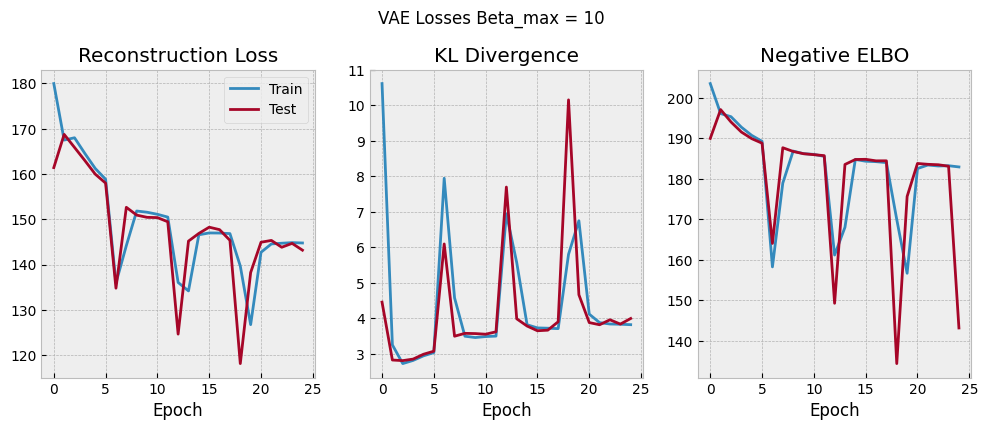

In [31]:
fig, axs = plot_losses(vae)
plt.show()

In [ ]:
def resume_training(trn_state_path: str, dataset: Dataset, epochs: int) -> VariationalAutoencoder:

    """
    Loads a model from a checkpoint file and continues training. Pass epochs=0
    to get a copy of the model at the end of training.
    """

    with open(trn_state_path, 'r') as f:
        trn_state = json.load(f)

    vae = VariationalAutoencoder(
        lr=trn_state["lr"],
        l1_dim=trn_state["l1_dim"],
        l2_dim=trn_state["l2_dim"],
        latent_dim=trn_state["latent_dim"],
        l4_dim=trn_state["l4_dim"],
        l5_dim=trn_state["l5_dim"],
        mse=trn_state["mse"]
    )

    vae.W1_enc = np.array(trn_state["weights"]["W1_enc"])
    vae.b1_enc = np.array(trn_state["weights"]["b1_enc"])
    vae.W2_enc = np.array(trn_state["weights"]["W2_enc"])
    vae.b2_enc = np.array(trn_state["weights"]["b2_enc"])
    vae.Wmu = np.array(trn_state["weights"]["Wmu"])
    vae.bmu = np.array(trn_state["weights"]["bmu"])
    vae.Wstd = np.array(trn_state["weights"]["Wstd"])
    vae.bstd = np.array(trn_state["weights"]["bstd"])
    vae.W1_dec = np.array(trn_state["weights"]["W1_dec"])
    vae.b1_dec = np.array(trn_state["weights"]["b1_dec"])
    vae.W2_dec = np.array(trn_state["weights"]["W2_dec"])
    vae.b2_dec = np.array(trn_state["weights"]["b2_dec"])
    vae.W3_dec = np.array(trn_state["weights"]["W3_dec"])
    vae.b3_dec = np.array(trn_state["weights"]["b3_dec"])

    vae._m = {k: np.array(trn_state["m"][k]) for k in trn_state["m"].keys()}
    vae._v = {k: np.array(trn_state["v"][k]) for k in trn_state["v"].keys()}
    vae.adam_t = trn_state["adam_t"]
    vae.adam_b1 = trn_state["adam_b1"]
    vae.adam_b2 = trn_state["adam_b2"]
    vae.adam_eps = trn_state["adam_eps"]
    vae.adam_lr = trn_state["lr"]

    vae.train_losses = trn_state["train_losses"]
    vae.test_losses = trn_state["test_losses"]

    train_ds = Subset(dataset, trn_state["trn_idxs"])
    test_ds = Subset(dataset, trn_state["tst_idxs"])

    vae.params_init = True

    if epochs!=0:
      vae.train(
          train_ds = train_ds,
          test_ds = test_ds,
          epochs = epochs,
          batch_size = trn_state["batch_size"],
          beta_max = trn_state["beta_max"],
          warmup_epochs = trn_state["wmp_epochs"],
          idxs_to_visualize = trn_state["idxs_to_visualize"],
          viz_dir = trn_state["viz_dir"],
          nrow = trn_state["nrow"],
          ncol = trn_state["ncol"]
      )
      vae.save_model_state(trn_state_path)

    return vae

In [ ]:
vae = resume_training(
    trn_state_path="/content/drive/MyDrive/VariationalAutoEncoders/models/VanillaVAE/linear_vae_params_2025-11-28-192256_beta=10",
    dataset=mnist_dataset,
    epochs=0
)

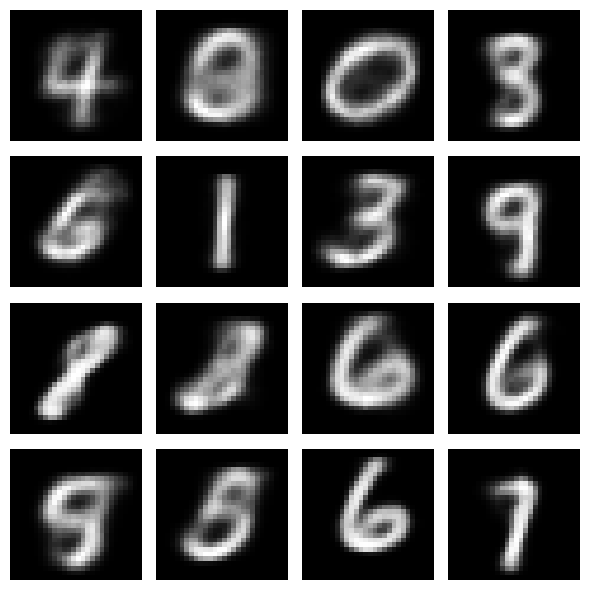

In [33]:
vae.generate_from_prior(n=16, scale=1, img_shape=(28, 28))

## Building the Convolutional Variational Auto encoder (CVAE)

In [3]:
class CBVAEncoder(nn.Module):
    def __init__(self, latent_dim: int, beta_max=1.0) -> None:
        super().__init__()
        self.latent_dim = latent_dim
        self.beta_max = beta_max
        self.beta = beta_max
        self.train_losses = {"Recon Loss": [], "KL Loss": [], "ELBO Loss": []}
        self.test_losses  = {"Recon Loss": [], "KL Loss": [], "ELBO Loss": []}

        self.encoder = nn.Sequential(
            # Bx3x64x64 -> Bx32x32x32
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            # Bx32x32x32 -> Bx64x16x16
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            # Bx64x16x16 -> Bx128x8x8
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            # Bx128x8x8 -> Bx256x4x4
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            # Bx(256*4*4)
            nn.Flatten(1),
            nn.Linear(256*4*4, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, latent_dim * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256*4*4),
            nn.LeakyReLU(0.2, inplace=True),
            # Bx256x4x4
            nn.Unflatten(1, (256, 4, 4)),
            # 4x4 -> 8x8
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            # 8x8 -> 16x16
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            # 16x16 -> 32x32
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            # 32x32 -> 64x64
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            # map outputs in [0,1]
            nn.Sigmoid(),
        )

    def set_beta(self, beta: float):
        self.beta = beta

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, X):
        enc_out = self.encoder(X)
        mu_phi, logvar_phi = torch.split(enc_out, self.latent_dim, dim=1)
        z = self.reparameterize(mu_phi, logvar_phi)
        Mu_x = self.decoder(z)
        return Mu_x, mu_phi, logvar_phi


    def kl_beta_cycle(self, t, T, num_cycs, beta_max=1.0, ratio=0.5):
        """
        Cyclical KL annealing from Fu et. al (2019).
        """
        steps_per_cycle = T // num_cycs             # number of times params are changed in one cycle
        cycle_pos = t % steps_per_cycle             # position within current cycle
        warmup_steps = int(ratio * steps_per_cycle)
        if cycle_pos < warmup_steps:
            # linearly increase beta from 0 to beta_max over warmup_steps
            return beta_max * (cycle_pos / warmup_steps)
        else:
          return beta_max

    def generate_from_prior(self, n, device, scale=1, img_shape=(3, 64, 64)):

        with torch.no_grad():
          # draw samples from gaussian prior for latent Z
          z = scale * np.random.randn(n, self.latent_dim)
          z = torch.from_numpy(z).to(torch.float32).to(device)
          # pass Z through decoder to generate images
          imgs = self.decoder(z)
          imgs = imgs.reshape(n, *img_shape)
          # imshow expects color channels to come last
          imgs = imgs.permute(0, 2, 3, 1).detach().cpu().numpy()
          k = int(np.ceil(np.sqrt(n)))
          fig, axs = plt.subplots(k, k, figsize=(6,6))
          for i, ax in enumerate(axs.flat):
              if i < len(imgs):
                  ax.imshow(imgs[i])
              ax.axis("off")
          plt.tight_layout()
          plt.show()


def loss(X, Mu_x, mu_phi, logvar_phi, recon_loss_fn, beta):
    # reconstruction loss
    recon_loss = recon_loss_fn(Mu_x, X)
    # KL divergence loss
    kl_div = (-0.5 * torch.mean(
        1 + logvar_phi - mu_phi.pow(2) - logvar_phi.exp(),
        dim=1
    )).mean()
    elbo = recon_loss + beta * kl_div
    return recon_loss, kl_div, elbo

In [6]:
def train(
    optimizer: torch.optim,
    model: CBVAEncoder,
    train_ds: Dataset,
    test_ds: Dataset,
    epochs:int,
    batch_size:int,
    idxs_to_visualize:List[int],
    viz_dir:str,
    nrow:int,
    ncol:int,
    device: torch.cuda.device
):

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    steps_per_epoch = int(np.ceil(len(train_ds) / batch_size))
    total_trn_steps = epochs * steps_per_epoch
    trn_step = 0  # keeps track of number of param updates for KL annealing

    for epoch in range(epochs):

        # init per-epoch running losses
        train_rl, train_kl, train_elbo = 0, 0, 0
        test_rl,  test_kl, test_elbo  = 0, 0, 0

        # training loop
        model.train()
        for i, (batch, lbls) in enumerate(train_loader):
            batch = batch.to(device)
            # clear grads
            optimizer.zero_grad()
            # compute new beta
            # beta = model.kl_beta_cycle(
            #     t = trn_step,
            #     T = total_trn_steps,
            #     num_cycs = 8,
            #     beta_max=model.beta_max,
            #     ratio=0.6
            # )
            model.set_beta(beta_max)
            # forward pass
            mu_x, mu, logvar = model(batch)
            # compute loss and accum
            recon_loss, kl_div, elbo = loss(batch, mu_x, mu, logvar, recon_loss_fn=nn.BCELoss(reduction="mean"), beta=model.beta)
            train_rl += float(recon_loss.detach())
            train_kl += float(kl_div.detach())
            train_elbo += float(elbo.detach())
            # backprop and optimization
            elbo.backward()
            optimizer.step()
            trn_step += 1

            # display batch loss info
            if i%10==9:
                print(f"Batch {i+1} | Recon Loss: {torch.round(recon_loss, decimals=4)} -------- KL Div: {torch.round(kl_div, decimals=4)}")

        # testing loop
        model.eval()
        with torch.no_grad():
            for i, (batch, lbls) in enumerate(test_loader):
                batch = batch.to(device)
                mu_x, mu, logvar = model(batch)
                recon_loss, kl_div, elbo = loss(batch, mu_x, mu, logvar, recon_loss_fn=nn.BCELoss(reduction="mean"), beta=model.beta)
                test_rl += float(recon_loss.detach())
                test_kl += float(kl_div.detach())
                test_elbo += float(elbo.detach())

            # visualize and save reconstructions of images in idxs_to_visualize
            if idxs_to_visualize is not None:
                  batch = torch.stack([test_ds[idx][0] for idx in idxs_to_visualize], dim=0)
                  batch = batch.to(device)
                  mu_x, mu, logvar = model(batch)
                  fig, axs = plt.subplots(nrow, ncol, figsize=(10, 10))
                  flt_axs = axs.flatten()
                  for i in range(len(idxs_to_visualize)):
                      flt_axs[i].imshow(mu_x[i].cpu().permute(1, 2, 0).numpy())
                      flt_axs[i].axis('off')
                      flt_axs[i].set_xticks([])
                      flt_axs[i].set_yticks([])
                  fig.tight_layout()
                  fig.savefig(
                      os.path.join(viz_dir, f"tst_visualizations_epoch{epoch+1}.jpg"),
                      dpi=300,
                      bbox_inches='tight'
                  )

        # loss updates
        test_rl /= len(test_loader)
        test_kl /= len(test_loader)
        test_elbo /= len(test_loader)
        train_rl /= len(train_loader)
        train_kl /= len(train_loader)
        train_elbo /= len(train_loader)
        model.test_losses["Recon Loss"].append(test_rl)
        model.test_losses["KL Loss"].append(test_kl)
        model.test_losses["ELBO Loss"].append(test_elbo)
        model.train_losses["Recon Loss"].append(train_rl)
        model.train_losses["KL Loss"].append(train_kl)
        model.train_losses["ELBO Loss"].append(train_elbo)

        # output
        print(f"EPOCH {epoch+1}")
        print(f"Train Recon Loss: {round(train_rl, 4)} ------ Train KL Div: {round(train_kl, 4)} ------ Train ELBO: {round(train_elbo, 4)}")
        print(f"Test Recon Loss: {round(test_rl, 4)} ------ Test KL Div: {round(test_kl, 4)} ------ Test ELBO: {round(test_elbo, 4)}")
        print('-'*60)

    return model, optimizer


In [ ]:
checkpoint_path = "/content/drive/MyDrive/VariationalAutoEncoders/models/CVAE/cvae_checkpoint.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# training vars
epochs = 50
batch_size = 64
lr = 0.001
beta_max = 1
latent_dim = 256
checkpoint_path = f"/content/drive/MyDrive/VariationalAutoEncoders/models/CVAE/cvae_checkpoint_beta={beta_max}.pth"

# visualization vars
num_to_vis = 12
nrow, ncol = 3, 4
viz_dir = f"/content/drive/MyDrive/VariationalAutoEncoders/imgs/CVAE/beta={beta_max}"
os.makedirs(viz_dir, exist_ok=True)

cvae = CBVAEncoder(latent_dim=latent_dim, beta_max=beta_max)
cvae.to(device)
optimizer = optim.Adam(cvae.parameters(), lr=lr)

# split data into testing and training splits
test_split = 0.1
test_size = int(test_split * len(lfw_dataset))
train_size  = len(lfw_dataset) - test_size

# creates Subset objects from orig. Dataset
train_ds, test_ds = random_split(lfw_dataset, [train_size, test_size])
train_idxs, test_idxs = train_ds.indices, test_ds.indices

# choose random images to visualze during training from test set
idxs = list(np.random.choice(np.arange(len(test_ds)), num_to_vis))

cvae, optimizer = train(
    optimizer = optimizer,
    model = cvae,
    train_ds = train_ds,
    test_ds = test_ds,
    epochs = epochs,
    batch_size = batch_size,
    idxs_to_visualize = idxs,
    viz_dir = viz_dir,
    nrow = nrow,
    ncol = ncol,
    device = device
)

checkpoint = {
    'model_state_dict': cvae.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epochs': epochs,
    'train_idxs': train_idxs,
    'test_idxs': test_idxs,
    'batch_size': batch_size,
    'lr': lr,
    'train_losses': cvae.train_losses,
    'test_losses': cvae.test_losses,
    'beta_max': cvae.beta_max,
    'beta': cvae.beta,
    'latent_dim': cvae.latent_dim,
    'idxs_to_visualize': idxs,
    'viz_dir': viz_dir,
    'nrow': nrow,
    'ncol': ncol
}
torch.save(checkpoint, checkpoint_path)

Batch 10 | Recon Loss: 0.6711000204086304 -------- KL Div: 9.999999747378752e-05
Batch 20 | Recon Loss: 0.6509000062942505 -------- KL Div: 0.00279999990016222
Batch 30 | Recon Loss: 0.6096000075340271 -------- KL Div: 0.011599999852478504
Batch 40 | Recon Loss: 0.6334999799728394 -------- KL Div: 0.005400000140070915
Batch 50 | Recon Loss: 0.6238999962806702 -------- KL Div: 0.006399999838322401
Batch 60 | Recon Loss: 0.6388999819755554 -------- KL Div: 0.005499999970197678
Batch 70 | Recon Loss: 0.6381999850273132 -------- KL Div: 0.00570000009611249
Batch 80 | Recon Loss: 0.6211000084877014 -------- KL Div: 0.007499999832361937
Batch 90 | Recon Loss: 0.6013000011444092 -------- KL Div: 0.008299999870359898
Batch 100 | Recon Loss: 0.6060000061988831 -------- KL Div: 0.010300000198185444
Batch 110 | Recon Loss: 0.5983999967575073 -------- KL Div: 0.01549999974668026
Batch 120 | Recon Loss: 0.6075999736785889 -------- KL Div: 0.009499999694526196
Batch 130 | Recon Loss: 0.6183000206947

In [ ]:
# count number of parameters in cvae
num_params = sum(p.numel() for p in cvae.parameters() if p.requires_grad)
print("Number of trainable parameters in model:", num_params)

Number of trainable parameters in model: 5973187


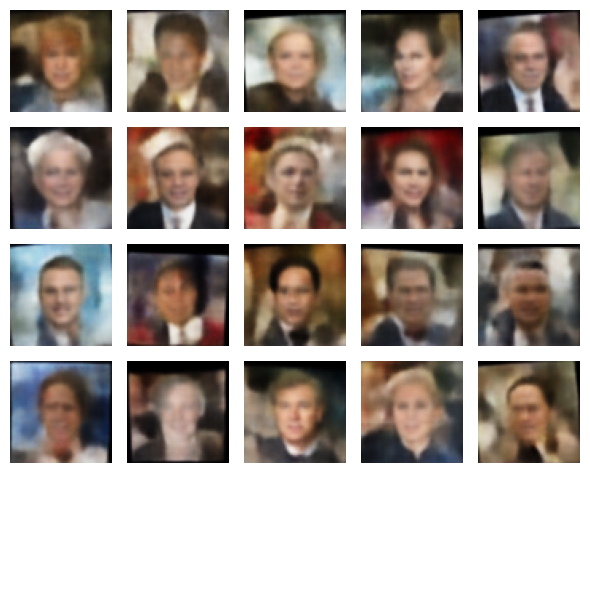

In [17]:
cvae.generate_from_prior(n=20, device=device, scale=1, img_shape=(3, 64, 64))

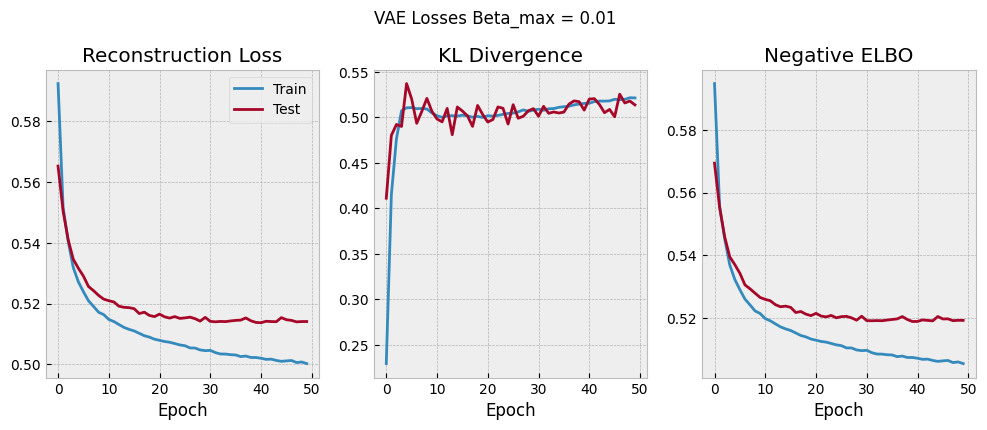

In [18]:
plot_losses(cvae)
plt.show()

{'Recon Loss': 'Recon Loss', 'KL Loss': 'KL Loss'}


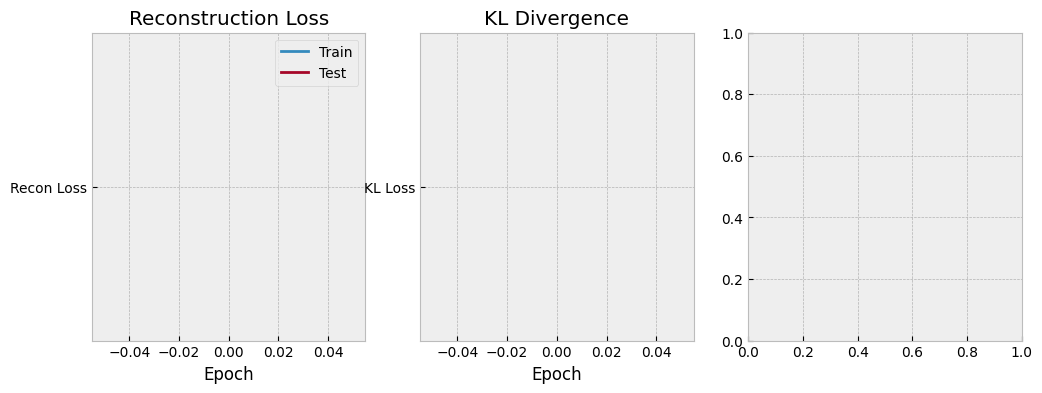

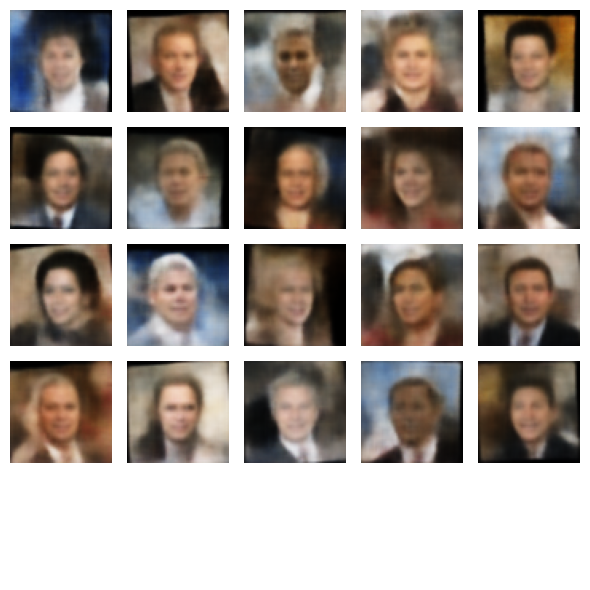

In [ ]:
def resume_training(checkpoint_path: str, dataset: Dataset, epochs: int, device):

    ckpt = torch.load(checkpoint_path, map_location=device, weights_only=False)

    # model hparams
    batch_size = ckpt["batch_size"]
    beta_max = ckpt["beta_max"]
    beta = ckpt["beta"]
    latent_dim = ckpt["latent_dim"]

    # create model and optimizer
    cvae = CBVAEncoder(latent_dim, beta_max)
    cvae.to(device)
    cvae.load_state_dict(ckpt["model_state_dict"])
    optimizer = optim.Adam(cvae.parameters(), lr=ckpt["lr"])
    optim_state = ckpt["optimizer_state_dict"]
    optimizer.load_state_dict(optim_state)

    # load datasets and split into training and testing
    train_ds = Subset(dataset, ckpt["train_idxs"])
    test_ds = Subset(dataset, ckpt["test_idxs"])

    # init per-epoch losses
    cvae.train_losses = ckpt["train_losses"]
    cvae.test_losses = ckpt["test_losses"]

    print(ckpt["train_losses"])

    cvae.set_beta(ckpt["beta"])

    # per-epoch visualization configs
    idxs_to_visualize = ckpt["idxs_to_visualize"]
    viz_dir = ckpt["viz_dir"]
    nrow = ckpt["nrow"]
    ncol = ckpt["ncol"]

    cvae, optimizer = train(
        optimizer = optimizer,
        model = cvae,
        train_ds = train_ds,
        test_ds = test_ds,
        epochs = epochs,
        batch_size = batch_size,
        idxs_to_visualize = idxs_to_visualize,
        viz_dir = viz_dir,
        nrow = nrow,
        ncol = ncol,
        device = device
    )

    # saved trained model
    checkpoint = {
        'model_state_dict': cvae.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epochs': ckpt["epochs"] + epochs,
        'train_idxs': ckpt["train_idxs"],
        'test_idxs': ckpt["test_idxs"],
        'batch_size': batch_size,
        'lr': ckpt["lr"],
        'train_losses': cvae.train_losses,
        'test_losses': cvae.test_losses,
        'beta_max': cvae.beta_max,
        'beta': cvae.beta,
        'latent_dim': cvae.latent_dim,
        'idxs_to_visualize': idxs_to_visualize,
        'viz_dir': viz_dir,
        'nrow': nrow,
        'ncol': ncol
    }
    torch.save(checkpoint, checkpoint_path)

    return cvae, optim


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

conv_vae, opt = resume_training(
    "/content/drive/MyDrive/VariationalAutoEncoders/models/CVAE/cvae_checkpoint_beta=0.05.pth",
    dataset=lfw_dataset,
    epochs=0,
    device=device
)

conv_vae.generate_from_prior(n=20, device=device, scale=1, img_shape=(3, 64, 64))

## Run this code if you only just want to use the pretrained models to generate new images

### MNIST Handwritten Digit Image Generation

### LFW Human Faces Image Generation